<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#데이터-생성" data-toc-modified-id="데이터-생성-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>데이터 생성</a></span><ul class="toc-item"><li><span><a href="#Prophet-라이브러리-사용" data-toc-modified-id="Prophet-라이브러리-사용-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Prophet 라이브러리 사용</a></span><ul class="toc-item"><li><span><a href="#전체-시계열로-예측" data-toc-modified-id="전체-시계열로-예측-1.1.1"><span class="toc-item-num">1.1.1&nbsp;&nbsp;</span>전체 시계열로 예측</a></span><ul class="toc-item"><li><span><a href="#날짜와-Y값으로만-예측" data-toc-modified-id="날짜와-Y값으로만-예측-1.1.1.1"><span class="toc-item-num">1.1.1.1&nbsp;&nbsp;</span>날짜와 Y값으로만 예측</a></span></li></ul></li><li><span><a href="#요일별-데이터로-예측" data-toc-modified-id="요일별-데이터로-예측-1.1.2"><span class="toc-item-num">1.1.2&nbsp;&nbsp;</span>요일별 데이터로 예측</a></span></li></ul></li></ul></li></ul></div>

# 데이터 생성

- 전체 시계열로 예측
    * 요일에 가중치 파생변수 두기
    * 모델 종류
        - Prophet : 결측치 제거하지 않아도 됨
        - ARIMA : 매출액에 대한 정상성 확보
        - 머신러닝 회귀모델
        - 딥러닝 RNN 모델
- 요일 시계열로 예측
    * 요일별로 데이터프레임 나누기
    * 요일별로 모델 생성

In [92]:
import pandas as pd
import numpy as np
import os
import warnings
warnings.filterwarnings(action='ignore')
os.chdir('/Users/younghun/Desktop/gitrepo/data/woochuri/')

In [99]:
df = pd.read_csv('./woochuri_final_data.csv')

## Prophet 라이브러리 사용
### 전체 시계열로 예측
- 결측치 제거하지 않아도 됨
- 원래는 날짜, Y값 변수만 넣지만 독립변수 추가는 가능함. 하지만 추가하면 미래의 Y값을 예측하기 위해 직전의 Y값을 쓰는 것이 아닌 추가된 독립변수만을 사용..

#### 날짜와 Y값으로만 예측

In [106]:
from fbprophet import Prophet

In [101]:
fb_df = df[['날짜', '일매출']]
# 일매출이 0인 값은 결측치로 다시 바꾸기
fb_df['일매출'] = fb_df['일매출'].replace(0, np.nan)
fb_df.isnull().sum()

날짜      0
일매출    86
dtype: int64

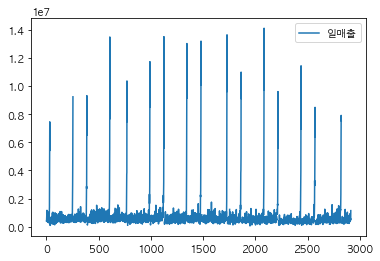

In [102]:
# 간단하게 시각화해보기
from matplotlib import pyplot
fb_df.plot()
pyplot.rc('font', family='AppleGothic')
pyplot.rcParams['axes.unicode_minus'] = False
pyplot.show()

In [103]:
# Split train, test data
splits = int(fb_df.shape[0] * 0.8)
train_df = fb_df.iloc[0: splits]
test_df = fb_df.iloc[splits:]
print("Train shape:", train_df.shape)
print("Test shape:", test_df.shape)

Train shape: (2332, 2)
Test shape: (583, 2)


In [104]:
# 칼럼명 날짜는 'ds'로 일매출은 'y'로 바꾸자
train_df.columns = ['ds', 'y']
test_df.columns = ['ds', 'y']
# 'ds' datetime type으로 바꾸기
train_df['ds'] = pd.to_datetime(train_df['ds'])
test_df['ds'] = pd.to_datetime(test_df['ds'])

In [107]:
# 모델 정의
model = Prophet()
# Train데이터로 학습
model.fit(train_df)

# Test데이터의 'ds'로 모델 평가
forecast = model.predict(test_df[['ds']])
test_df['y_pred'] = forecast['yhat'].values

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [113]:
from sklearn.metrics import mean_absolute_error
test = test_df.dropna()
mae = mean_absolute_error(test['y'], test['y_pred'])
print("MAE:", mae)

MAE: 389379.4545916285


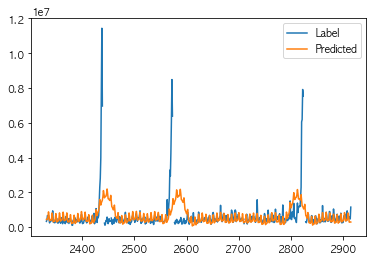

In [115]:
pyplot.plot(test_df['y'], label='Label')
pyplot.plot(test_df['y_pred'], label='Predicted')
pyplot.legend()
pyplot.show()

- 아무리 Holiday 요소를 고려한다 해도 추석, 설날 주변의 특이 이상치를 예측하지 못한다..

In [121]:
# 이상치를 제거하고 예측해보자
out_fb_df = df.loc[df['설_추석_가중치'] == 0, ['날짜', '일매출']]
splits = int(fb_df.shape[0] * 0.8)
train_df = out_fb_df.iloc[:splits]
test_df = out_fb_df.iloc[splits:]

train_df.columns = ['ds', 'y']
test_df.columns = ['ds', 'y']
train_df['ds'] = pd.to_datetime(train_df['ds'])
test_df['ds'] = pd.to_datetime(test_df['ds'])

In [125]:
# 모델 정의, 학습
model = Prophet()
model.fit(train_df)

# Test 데이터에 대해 모델 예측
forecast = model.predict(test_df[['ds']])
test_df['y_pred'] = forecast['yhat'].values

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [128]:
test = test_df.dropna()
mae = mean_absolute_error(test['y'], test['y_pred'])
print("MAE:", mae)

MAE: 254080.33156528362


### 요일별 데이터로 예측

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Friday의 MAE: 433185.66


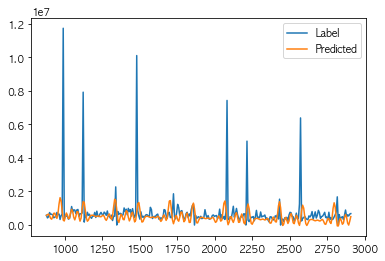

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


--------------------------------------------------
Monday의 MAE: 352026.29


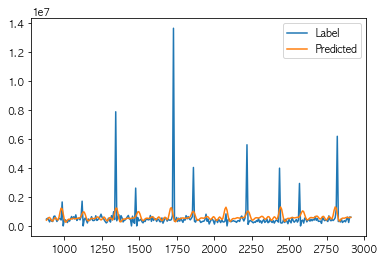

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


--------------------------------------------------
Saturday의 MAE: 794679.53


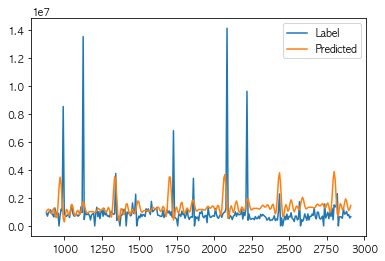

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


--------------------------------------------------
Sunday의 MAE: 965775.53


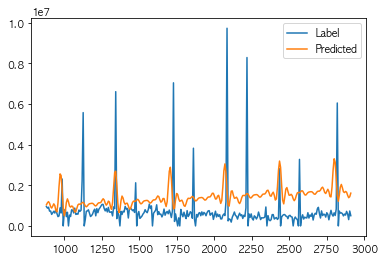

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


--------------------------------------------------
Thursday의 MAE: 359964.51


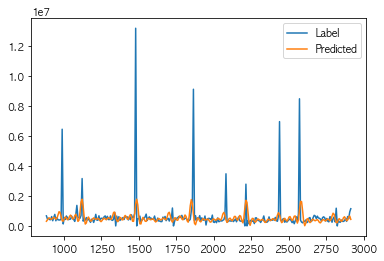

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


--------------------------------------------------
Tuesday의 MAE: 622067.25


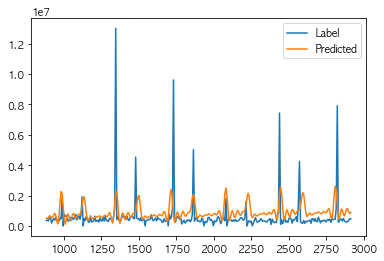

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


--------------------------------------------------
Wednesday의 MAE: 423828.94


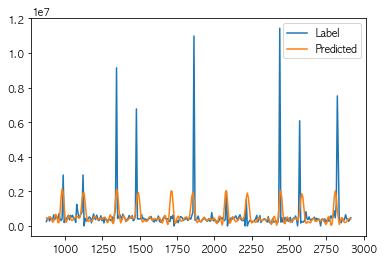

--------------------------------------------------


In [165]:
import math
fb_df = df[['날짜', '일매출', '요일']]
grouped = fb_df.groupby('요일')
weekday_lst = list(grouped.groups.keys())
for i, g in enumerate(grouped.groups):
    group = grouped.get_group(g)
    group = group[['날짜', '일매출']]
    group.columns = ['ds', 'y']

    splits = math.ceil(group.shape[0] * 0.3)
    train_df = group.iloc[:splits]
    test_df = group.iloc[splits:]
    # 모델 정의
    model = Prophet()
    model.fit(train_df)
    # 모델 평가
    forecast = model.predict(test_df[['ds']])
    test_df['y_pred'] = forecast['yhat'].values
    # 모델 성능 측정
    mae = mean_absolute_error(test_df['y'], test_df['y_pred'])
    print(f"{weekday_lst[i]}의 MAE: {mae :.2f}")
    pyplot.plot(test_df['y'], label='Label')
    pyplot.plot(test_df['y_pred'], label='Predicted')
    pyplot.legend()
    pyplot.show()
    print('-'*50)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Friday의 MAE: 223465.77


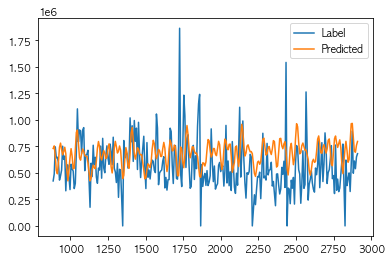

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


--------------------------------------------------
Monday의 MAE: 274909.42


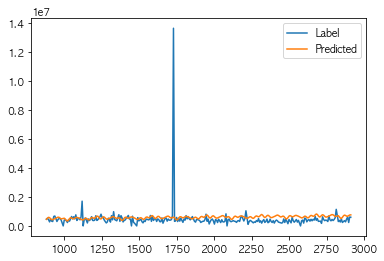

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


--------------------------------------------------
Saturday의 MAE: 371460.66


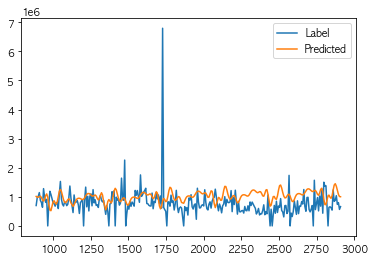

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


--------------------------------------------------
Sunday의 MAE: 390815.21


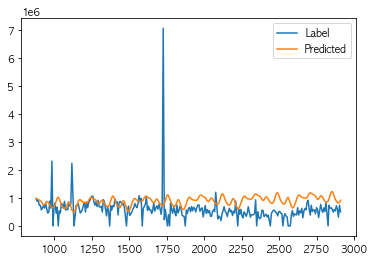

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


--------------------------------------------------
Thursday의 MAE: 233623.97


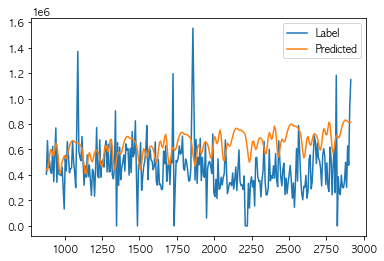

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


--------------------------------------------------
Tuesday의 MAE: 287527.86


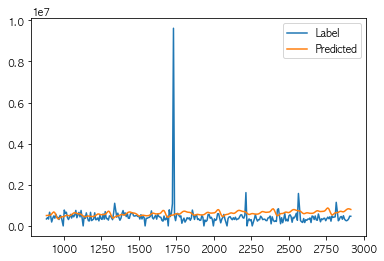

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


--------------------------------------------------
Wednesday의 MAE: 149924.24


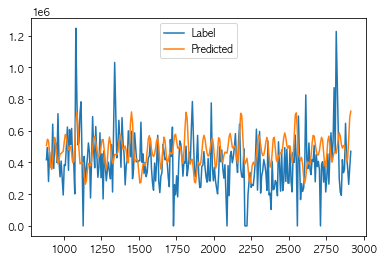

--------------------------------------------------


In [164]:
# 이상치 데이터를 제거하고 재시도
import math
fb_df = df.loc[df['설_추석_가중치'] == 0, ['날짜', '일매출', '요일']]
grouped = fb_df.groupby('요일')
weekday_lst = list(grouped.groups.keys())
for i, g in enumerate(grouped.groups):
    group = grouped.get_group(g)
    group = group[['날짜', '일매출']]
    group.columns = ['ds', 'y']

    splits = math.ceil(group.shape[0] * 0.3)
    train_df = group.iloc[:splits]
    test_df = group.iloc[splits:]
    # 모델 정의
    model = Prophet()
    model.fit(train_df)
    # 모델 평가
    forecast = model.predict(test_df[['ds']])
    test_df['y_pred'] = forecast['yhat'].values
    # 모델 성능 측정
    mae = mean_absolute_error(test_df['y'], test_df['y_pred'])
    print(f"{weekday_lst[i]}의 MAE: {mae :.2f}")
    pyplot.plot(test_df['y'], label='Label')
    pyplot.plot(test_df['y_pred'], label='Predicted')
    pyplot.legend()
    pyplot.show()
    print('-'*50)

- 전체 시계열보다 요일별 모델이 더 에러값이 적다
- 추석_설_가중치가 있는 값들 즉, 설,추석 연휴 매출이 높은 값들을 제거하는 것이 오히려 더 정확했다..하지만 이렇게 하면 미래에 맞이할 설,추석 연휴 매출을 예측하기가 어려워짐..

In [ ]:
# 어떻게 개선해야 할까.. 생각좀해보자...
# Prophet을 더 개선해야 하는지
# ARIMA는 보나마나 못맞출 것 같고..
# 머신러닝, 딥러닝을 사용해야 하나..
# 데이터가 적다보니 앙상블 모델을 하는 것도 좋을 듯 하다..